# Code to analyze the S-PLUS mock 

In [30]:
#Importing modules
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
from os import listdir
from os.path import isfile, join
import h5py
import scipy
from scipy import optimize as opt
from scipy import *
from numpy import *
from pylab import *
from scipy.integrate import quad

from scipy.integrate import quad
import astropy.io.ascii as at
from matplotlib.lines import Line2D
import matplotlib
import matplotlib.figure as fig
from matplotlib import rc
import tqdm
from astropy.io import fits
from scipy.special import ndtri
import numpy as np

Error function

In [31]:
from scipy.special import ndtri
import numpy as np
def rb_wilsonscore(count,nobs,confint):
	#-----------------------------------------------------------------------------------
	# This function computes the wilson score confidence intervals Score Interval for a binomial distribution.
	#
	#     Input :     count   =    Number of successes
	#                 nobs    =    Number of total Trials
	#                 confint =    Confindence interval for which Wilson Score is computed [e.g. confint =0.95 2\sigma]
	#
	#     Output
	#				  center =  gives the center of the score intervals given the data
	#                 hi     =   Upper bound for given confint
	#                 lo     =   Lower bound for given confint
	#
	#     Example:    import rb_wilsonscore as w
	#                 XC, hi, lo = w.rb_wilsonscore(10.,20.,.95)
	#
	#     Written by :   Rongmon Bordoloi  Nov 2017
	#     Tested on  : Python 2.7, 3.x
	#-----------------------------------------------------------------------------------
	count=np.double(count)
	nobs=np.double(nobs)
	confint=np.double(confint)
	# Written by RB
	if nobs == 0.0: return (0.0,0.5 ,1.0)
	z = ndtri(1. - 0.5 * (1.-confint))
	p=count/nobs
	# now do it with Wilson score interval
	alpha=(p+ (z*z)/(2.*nobs))
	beta=((p*(1.-p)/ nobs) + ((z**2.)/(4.*(nobs**2.))))**0.5
	center = (alpha) / (1. + ((z**2.)/ nobs))
	hi = (alpha+ (z*beta))/ (1. + ((z**2.)/ nobs))
	lo = (alpha - z*(beta)) / (1. + ((z**2.)/ nobs))
	return (center,hi,lo)

rb_wilsonscore=vectorize(rb_wilsonscore)

Reading detected clusters (matched)

In [32]:
hdulist = fits.open('/home/stephanewerner/Documents/pzwav_2021/new_lightcone/output/detected_clusters.fits')
scidata = hdulist[1].data
prihdr = hdulist[0].header
sechdr= hdulist[1].header

ID_det=[]
ID_mock=[]
riqueza =[]
rank =[]
m200 =[]
dist =[]
z_spec1=[]
zdet=[]
zerrdet=[]
RA_det=[]
DEC_det =[]
Ra_cls=[]
Dec_cls =[]
SN_det=[]

for i in range(len(scidata)):
    ID_det.append(scidata[i][0])
    ID_mock.append(scidata[i][1])
    riqueza.append(scidata[i][2])
    rank.append(scidata[i][3])
    m200.append(scidata[i][4])
    dist.append(scidata[i][5])
    z_spec1.append(scidata[i][6])
    zdet.append(scidata[i][7])
    zerrdet.append(scidata[i][8])
    RA_det.append(scidata[i][9])
    DEC_det.append(scidata[i][10])
    Ra_cls.append(scidata[i][11])
    Dec_cls.append(scidata[i][12])
    SN_det.append(scidata[i][13])


ID_det= np.array(ID_det)
ID_mock= np.array(ID_mock)
riqueza = np.array(riqueza)
rank = np.array(rank)
m200 = np.array(m200)
dist =np.array(dist)
z_spec1=np.array(z_spec1)
zdet=np.array(zdet)
zerrdet=np.array(zerrdet)
RA_det= np.array(RA_det)
DEC_det =np.array(DEC_det)
Ra_cls=np.array(Ra_cls)
Dec_cls = np.array(Dec_cls)
SN_det=np.array(SN_det)


table = np.zeros((len(ID_det), 14))
table[:,0] = ID_det
table[:,1] = ID_mock
table[:,2] = riqueza
table[:,3] = rank
table[:,4] = 10**m200
table[:,5] = dist
table[:,6] = z_spec1
table[:,7] = zdet
table[:,8] = zerrdet
table[:,9] = RA_det
table[:,10] = DEC_det
table[:,11] = Ra_cls
table[:,12] = Dec_cls
table[:,13] = SN_det

data_final1 = table


Reading mock catalogue

In [40]:
os.chdir('/home/stephanewerner/Documents/pzwav_2020')
hdulist = fits.open('clusters_lightcone.fits')
scidata = hdulist[1].data
prihdr = hdulist[0].header
sechdr= hdulist[1].header

ra_real=[]
dec_real =[]
z_real =[]
m_real = []

for i in range(len(scidata)):
    ra_real.append(scidata[i][0])
    dec_real.append(scidata[i][1])
    z_real.append(scidata[i][2])
    m_real.append(scidata[i][3])


ra_cls = np.array(ra_real)
dec_cls = np.array(dec_real)
z_cls = np.array(z_real)
logM200_cls = np.array(m_real)

ID_cls = np.arange(10000000,10000000+len(z_cls),1)

matrix = np.zeros((len(ra_real), 5))
matrix[:,0] = ra_cls
matrix[:,1] = dec_cls
matrix[:,2] = z_cls
matrix[:,3] = ID_cls
matrix[:,4] = logM200_cls

######################################################################
#Excluding the clusters that have z>0.40 and logM200<13.5

matrix = matrix[np.where((matrix[:,2]<0.4) & (matrix[:,4]>13.0))]

Reading PZWAV output

In [41]:
hdulist = fits.open('/home/stephanewerner/Documents/pzwav_2021/new_lightcone/output/detclPZWAV_CFC4M2A322.67H21SN0.2V2.1.fits')
scidata = hdulist[1].data
prihdr = hdulist[0].header
sechdr= hdulist[1].header
#We need to create an ID and a rank using the S/N

ra_det=[]
dec_det =[]
z_det =[]
id_det=[]
riq_det =[]
rank_det =[]
zerr_det=[]
sn_det=[]

for i in range(len(scidata)):
    ra_det.append(scidata[i][1])
    dec_det.append(scidata[i][2])
    z_det.append(scidata[i][3])
    zerr_det.append(scidata[i][4])
    id_det.append(i)
    riq_det.append(scidata[i][6])
    rank_det.append(scidata[i][8])
    sn_det.append(scidata[i][5])

ra_det = np.array(ra_det)
dec_det = np.array(dec_det)
z_det = np.array(z_det)
id_det = np.array(id_det)
riq_det = np.array(riq_det)
rank_det = np.array(rank_det)
zerr_det = np.array(zerr_det)
sn_det = np.array(sn_det)

table = np.zeros((len(rank_det), 8))
table[:,0] = ra_det
table[:,1] = dec_det
table[:,2] = z_det
table[:,3] = id_det
table[:,4] = riq_det
table[:,5] = rank_det
table[:,6] = zerr_det
table[:,7] = sn_det

### Completeness vs true redshift

<Figure size 432x288 with 0 Axes>

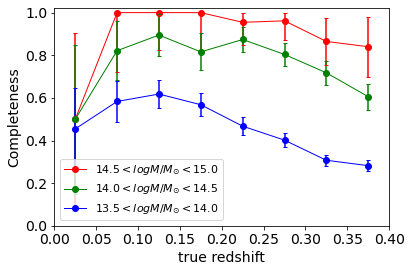

In [49]:

MASS_BINS =[13.5, 14.0, 14.5, 15.0]
detected_real = 0
total_true = 0
z_range = np.arange(0.0, 0.45, 0.05)
detected_real_vect =[]
total_true_vect =[]

final1 = data_final1[np.where((np.log10(data_final1[:,4])>14.5) & (np.log10(data_final1[:,4])<15.0) & (data_final1[:,13]>4.0))]

for k in range(len(z_range)-1):
	detected_real = 0.0
	for i in range(len(final1)):
		if z_range[k] <final1[i,6] < z_range[k+1]:
			detected_real = detected_real +1
	detected_real_vect.append(detected_real)

matrix_new1 = matrix[np.where((matrix[:,4]>14.5) & (matrix[:,4]<15.0))]
for k in range(len(z_range)-1):
	total_true =0.0
	for i in range(len(matrix_new1)):
		if z_range[k]<matrix_new1[i,2]< z_range[k+1]:
			total_true = total_true +1
	total_true_vect.append(total_true)

detected = np.array(detected_real_vect)
total = np.array(total_true_vect)
completeness = np.arange(0.0, len(total),1.0)

for i in range(len(detected)):
	if total[i] == 0:
		completeness[i] = 100000000.0
	else:
		completeness[i] =detected[i]/total[i]
		#print(detected[i])
		#print(total[i])

zs=[]
for i in range(len(z_range)-1):
    zs.append((z_range[i]+z_range[i+1])/2.0)

zs= np.array(zs)
'{:.2e}'.format(zs[0])
compz = np.zeros((len(completeness), 2))
compz[:,0] = zs
compz[:,1] = completeness
#compz = comp_z[np.where(comp_z[:,1] != 100000000.0)]


#erros
#rb_wilsonscore=vectorize(rb_wilsonscore)
erros1 = rb_wilsonscore(detected,total_true_vect,0.95)
error_sup= erros1[1]- erros1[0]
error_inf= erros1[0]- erros1[2]
error_sup = error_sup
error_inf = error_inf

#plot
xerror =[]
for i in range(len(compz)-1):
	xerror.append((compz[i,0] + compz[i+1,0])/2.0)

uplims = compz[:,1] + error_sup

for i in range(len(uplims)):
	if uplims[i]>1.0:
		error_sup[i] = 1.0 - compz[i,1]



plt.clf()
fig,ax =plt.subplots()
ax.plot(compz[:,0], compz[:,1], '-ro', color= 'red',label =r'$14.5<log M/M_{\odot}<15.0$',linewidth=1.0 )
#plt.errorbar(compz[:,0] ,compz[:,1], yerr = erros1, fmt = 'none', color = 'crimson')
plt.errorbar(compz[:,0] ,compz[:,1], yerr = [error_inf,error_sup], fmt = 'none', color = 'red', capsize=2.0)


################################################################################
#Another mass bin

detected_real = 0
total_true = 0

detected_real_vect =[]
total_true_vect =[]

final1 = data_final1[np.where((np.log10(data_final1[:,4])>14.0) & (np.log10(data_final1[:,4])<14.5) & (data_final1[:,13]>4.0))]

for k in range(len(z_range)-1):
	detected_real = 0.0
	for i in range(len(final1)):
		if z_range[k] <final1[i,6] < z_range[k+1]:
			detected_real = detected_real +1
	detected_real_vect.append(detected_real)

matrix_new1 = matrix[np.where((matrix[:,4]>14.0) & (matrix[:,4]<14.5))]
for k in range(len(z_range)-1):
	total_true =0.0
	for i in range(len(matrix_new1)):
		if z_range[k]<matrix_new1[i,2]< z_range[k+1]:
			total_true = total_true +1
	total_true_vect.append(total_true)

detected = np.array(detected_real_vect)
total = np.array(total_true_vect)
completeness = np.arange(0.0, len(total),1.0)

for i in range(len(detected)):
	if total[i] == 0:
		completeness[i] = 100000000.0
	else:
		completeness[i] =detected[i]/total[i]
		#print(detected[i])
		#print(total[i])

zs = []
for i in range(len(z_range) - 1):
    zs.append((z_range[i] + z_range[i + 1]) / 2.0)

zs= np.array(zs)
'{:.2e}'.format(zs[0])
compz = np.zeros((len(completeness), 2))
compz[:,0] = zs
compz[:,1] = completeness
#compz = comp_z[np.where(comp_z[:,1] != 100000000.0)]


#erros
#rb_wilsonscore=vectorize(rb_wilsonscore)
erros1 = rb_wilsonscore(detected,total_true_vect,0.95)
error_sup= erros1[1]- erros1[0]
error_inf= erros1[0]- erros1[2]
error_sup = error_sup
error_inf = error_inf

#plot
xerror =[]
for i in range(len(compz)-1):
	xerror.append((compz[i,0] + compz[i+1,0])/2.0)

uplims = compz[:,1] + error_sup

for i in range(len(uplims)):
	if uplims[i]>1.0:
		error_sup[i] = 1.0 - compz[i,1]



ax.plot(compz[:,0], compz[:,1], '-ro', color= 'green',label =r'$14.0<log M/M_{\odot}<14.5$',linewidth=1.0)
#plt.errorbar(compz[:,0] ,compz[:,1], yerr = erros1, fmt = 'none', color = 'rebeccapurple')
plt.errorbar(compz[:,0] ,compz[:,1], yerr = [error_inf,error_sup], fmt = 'none', color = 'green', capsize=2.0)

################################################################################
#Another mass bin

detected_real = 0
total_true = 0
detected_real_vect =[]
total_true_vect =[]

final1 = data_final1[np.where((np.log10(data_final1[:,4])>13.5) & (np.log10(data_final1[:,4])<14.0) & (data_final1[:,13]>4.0))]

for k in range(len(z_range)-1):
	detected_real = 0.0
	for i in range(len(final1)):
		if z_range[k] <final1[i,6] < z_range[k+1]:
			detected_real = detected_real +1
	detected_real_vect.append(detected_real)

matrix_new1 = matrix[np.where((matrix[:,4]>13.5) & (matrix[:,4]<14.0))]
for k in range(len(z_range)-1):
	total_true =0.0
	for i in range(len(matrix_new1)):
		if z_range[k]<matrix_new1[i,2]< z_range[k+1]:
			total_true = total_true +1
	total_true_vect.append(total_true)

detected = np.array(detected_real_vect)
total = np.array(total_true_vect)
completeness = np.arange(0.0, len(total),1.0)

for i in range(len(detected)):
	if total[i] == 0:
		completeness[i] = 100000000.0
	else:
		completeness[i] =detected[i]/total[i]
		#print(detected[i])
		#print(total[i])

zs = []
for i in range(len(z_range) - 1):
    zs.append((z_range[i] + z_range[i + 1]) / 2.0)

zs= np.array(zs)
'{:.2e}'.format(zs[0])
compz = np.zeros((len(completeness), 2))
compz[:,0] = zs
compz[:,1] = completeness
#compz = comp_z[np.where(comp_z[:,1] != 100000000.0)]


#erros
#rb_wilsonscore=vectorize(rb_wilsonscore)
erros1 = rb_wilsonscore(detected,total_true_vect,0.95)
error_sup= erros1[1]- erros1[0]
error_inf= erros1[0]- erros1[2]
error_sup = error_sup
error_inf = error_inf


#plot
xerror =[]
for i in range(len(compz)-1):
	xerror.append((compz[i,0] + compz[i+1,0])/2.0)

uplims = compz[:,1] + error_sup

for i in range(len(uplims)):
	if uplims[i]>1.0:
		error_sup[i] = 1.0 - compz[i,1]

ax.plot(compz[:,0], compz[:,1], '-ro', color= 'blue',label =r'$13.5<log M/M_{\odot}<14.0$',linewidth=1.0)
#plt.errorbar(compz[:,0] ,compz[:,1], yerr = erros1, fmt = 'none', color = 'teal')
plt.errorbar(compz[:,0] ,compz[:,1], yerr = [error_inf,error_sup], fmt = 'none', color = 'blue',capsize=2.0)
plt.xlabel('true redshift',fontsize = 14.0)
plt.ylabel('Completeness',fontsize = 14.0)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.axis((0.0,0.40,0.0,1.02))
ax.legend(fontsize =11.0, loc = 'lower left')
plt.show()


### Completeness vs Purity for different redshifts - SN>4.0 

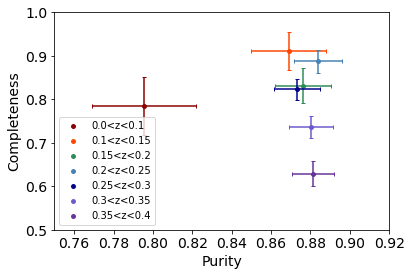

[0.7837837837837838, 0.9111111111111111, 0.8313253012048193, 0.8873239436619719, 0.8227848101265823, 0.7372013651877133, 0.6292134831460674]
[0.06682975893483067, 0.04265810458222152, 0.04082049838729929, 0.02643224056089022, 0.024651617908453383, 0.025540979438882894, 0.029345821357662727]
[0.7956521739130434, 0.8690095846645367, 0.8761552680221811, 0.8838526912181303, 0.8731343283582089, 0.8801897983392646, 0.8813559322033898]
[0.02641415178306905, 0.018970459636122428, 0.014087584771762529, 0.011995272926393463, 0.011674521189256715, 0.011125039358467648, 0.010812043009900019]


In [42]:
color1 = 'darkred'
color2 = 'orangered'
color3 = 'seagreen'
color4 = 'steelblue'
color5 = 'darkblue'
color6 =  'slateblue'
color7 =  'rebeccapurple'
color8 = 'indigo'
color9=  'crimson'

colors = [color1, color2, color3, color4, color5, color6, color7, color8,color9]
SN = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
matrix_new1=matrix[np.where((matrix[:,2]<0.4) & (matrix[:,4]>14.0) & (matrix[:,2]>0.1) )]

z =[0.0,0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4]
purity_vect = []
completeness_vect = []
erros_comp_vect =[]
erros_purity_vect = []

for i in range(len(z)-1):
	matrix_new1=matrix[np.where((matrix[:,2]<z[i+1]) & (matrix[:,4]>14.0) & (matrix[:,2]>z[i]) )]
	final1 = data_final1[np.where((data_final1[:,4]>10**14.0) & (data_final1[:,6]<z[i+1])& (data_final1[:,6]>z[i])&(data_final1[:,13]>4.0))[0]]
	detected_real = len(final1)
	total_true = len(matrix_new1)
	completeness = detected_real/total_true
	completeness_vect.append(completeness)
	#erros
	erros1 = rb_wilsonscore(detected_real,total_true,0.68)
	erros_completeza = erros1[1]-erros1[0]
	erros_comp_vect.append(erros_completeza)
	#Vamos agora calcular a pureza
	final1 = data_final1[np.where((data_final1[:,7]<z[i+1])& (data_final1[:,7]>z[i])&(data_final1[:,13]>4))]
	detected_real2 = len(final1)
	table7 = table[np.where((table[:,7] > 4.0) &  (table[:,2] < z[i+1]) & (table[:,2] > z[i]))[0]]
	total_det = len(table7)
	purity = detected_real2/total_det
	purity_vect.append(purity)
	#erros#############################################################
	erros1 = rb_wilsonscore(detected_real2,total_det,0.68)
	erros_pureza = erros1[1]-erros1[0]
	erros_purity_vect.append(erros_pureza)
	#fazendo o gráfico
	plt.scatter(purity, completeness, s = 15.0, marker = "o", label = str(z[i])+'<z<'+str(z[i+1]), color = colors[i])
	plt.errorbar(purity, completeness, yerr = erros_completeza, fmt = 'none', color = colors[i],capsize=2.0)
	plt.errorbar(purity, completeness, xerr = erros_pureza, fmt = 'none', color = colors[i],capsize=2.0)

#print(purity)
#print(completeness)
#######################################################################################################
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Purity',fontsize =14.0)
plt.ylabel('Completeness', fontsize =14.0)
plt.axis((0.75,0.92,0.5,1.0))
plt.legend(fontsize ='medium', loc = 'lower left')
plt.show()	

print(completeness_vect)
print(erros_comp_vect)
print(purity_vect)
print(erros_purity_vect)

### Completeness vs purity for different masses - SN>4.0

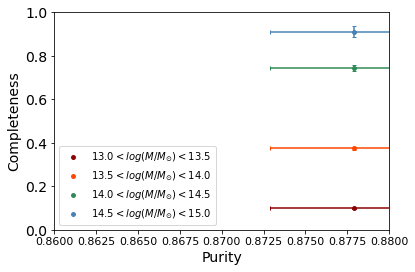

[0.0986159169550173, 0.3741965105601469, 0.7430703624733476, 0.9112903225806451]
[0.00241866577652905, 0.007290634958609599, 0.014182375878125875, 0.025499416716274315]
[0.8778932451582427, 0.8778932451582427, 0.8778932451582427, 0.8778932451582427]
[0.005004013735838586, 0.005004013735838586, 0.005004013735838586, 0.005004013735838586]


In [48]:
mass =[13.0, 13.5, 14.0, 14.5, 15.0]
purity_vect = []
completeness_vect = []
erros_comp_vect =[]
erros_purity_vect = []

for i in range(len(mass)-1):
	matrix_new1=matrix[np.where((matrix[:,2]<0.4) & (matrix[:,4]>mass[i]) & (matrix[:,4]<mass[i+1])& (matrix[:,2]>0.1) )]
	final1 = data_final1[np.where((data_final1[:,4]>10**mass[i])&(data_final1[:,4]<10**mass[i+1])  & (data_final1[:,6]<0.4)& (data_final1[:,6]>0.1)&(data_final1[:,13]>4.0))[0]]
	detected_real = len(final1)
	total_true = len(matrix_new1)
	completeness = detected_real/total_true
	completeness_vect.append(completeness)
	#erros
	erros1 = rb_wilsonscore(detected_real,total_true,0.68)
	erros_completeza = erros1[1]-erros1[0]
	erros_comp_vect.append(erros_completeza)
	#Vamos agora calcular a pureza
	final1 = data_final1[np.where((data_final1[:,7]<0.4)& (data_final1[:,7]>0.1)&(data_final1[:,13]>4))]
	detected_real2 = len(final1)
	table7 = table[np.where((table[:,7] > 4.0) &  (table[:,2] < 0.4) & (table[:,2] > 0.1))[0]]
	total_det = len(table7)
	purity = detected_real2/total_det
	purity_vect.append(purity)
	#erros#############################################################
	erros1 = rb_wilsonscore(detected_real2,total_det,0.68)
	erros_pureza = erros1[1]-erros1[0]
	erros_purity_vect.append(erros_pureza)
	#fazendo o gráfico
	plt.scatter(purity, completeness, s = 15.0, marker = "o", label = str(mass[i])+r'$<log(M/M_{\odot})<$'+str(mass[i+1]), color = colors[i])
	plt.errorbar(purity, completeness, yerr = erros_completeza, fmt = 'none', color = colors[i],capsize=2.0)
	plt.errorbar(purity, completeness, xerr = erros_pureza, fmt = 'none', color = colors[i],capsize=2.0)

#######################################################################################################
plt.xticks(fontsize=11)
plt.yticks(fontsize=14)
plt.xlabel('Purity',fontsize =14.0)
plt.ylabel('Completeness', fontsize =14.0)
plt.axis((0.86,0.88,0.0,1.0))
plt.legend(fontsize ='medium', loc = 'lower left')
plt.show()	

print(completeness_vect)
print(erros_comp_vect)
print(purity_vect)
print(erros_purity_vect)

### Completeness vs purity for different SN

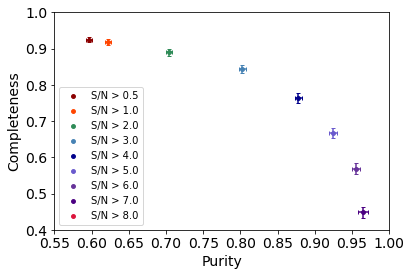

[0.9250234301780693, 0.9184629803186504, 0.8894095595126523, 0.8444236176194939, 0.7638238050609185, 0.6663542642924086, 0.5679475164011246, 0.44892221180880976, 0.3542642924086223]
[0.008023526034717787, 0.008336445698570394, 0.009550420195752585, 0.011034090186393453, 0.012926925295488667, 0.014349059057141234, 0.01507402233611066, 0.015135512696680675, 0.014555018945761722]
[0.5963292228276456, 0.6220570786236184, 0.7038645245332176, 0.8023499790180445, 0.8778932451582427, 0.9242362525458249, 0.9550794747753973, 0.9648526077097506, 0.9738675958188153]
[0.00369504965224865, 0.00381035735931734, 0.004230865800337158, 0.0046836170407963396, 0.005004013735838586, 0.005312757998794493, 0.005422014343823167, 0.006184861829193089, 0.006666024254465941]


In [44]:
colors = [color1, color2, color3, color4, color5, color6, color7, color8,color9]
SN = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
matrix_new1=matrix[np.where((matrix[:,2]<0.4) & (matrix[:,4]>14.0) & (matrix[:,2]>0.1) )]

purity_vect = []
completeness_vect = []
erros_comp_vect =[]
erros_purity_vect = []
for i in range(len(SN)):
	final1 = data_final1[np.where((data_final1[:,4]>10**14.0) & (data_final1[:,6]<0.40)& (data_final1[:,6]>0.1)&(data_final1[:,13]>SN[i]))[0]]
	detected_real = len(final1)
	total_true = len(matrix_new1)
	completeness = detected_real/total_true
	completeness_vect.append(completeness)
	#erros
	erros1 = rb_wilsonscore(detected_real,total_true,0.68)
	erros_completeza = erros1[1]-erros1[0]
	erros_comp_vect.append(erros_completeza)
	#Vamos agora calcular a pureza
	final1 = data_final1[np.where((data_final1[:,7]<0.4)& (data_final1[:,7]>0.1)&(data_final1[:,13]>SN[i]))]
	detected_real2 = len(final1)
	table7 = table[np.where((table[:,7] > SN[i]) &  (table[:,2] < 0.40) & (table[:,2] > 0.10))[0]]
	total_det = len(table7)
	purity = detected_real2/total_det
	purity_vect.append(purity)
	#erros#############################################################
	erros1 = rb_wilsonscore(detected_real2,total_det,0.68)
	erros_pureza = erros1[1]-erros1[0]
	erros_purity_vect.append(erros_pureza)
	#fazendo o gráfico
	plt.scatter(purity, completeness, s = 15.0, marker = "o", label = 'S/N > '+str(SN[i]), color = colors[i])
	plt.errorbar(purity, completeness, yerr = erros_completeza, fmt = 'none', color = colors[i],capsize=2.0)
	plt.errorbar(purity, completeness, xerr = erros_pureza, fmt = 'none', color = colors[i],capsize=2.0)

#######################################################################################################
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Purity',fontsize =14.0)
plt.ylabel('Completeness', fontsize =14.0)
plt.axis((0.55,1.0,0.4,1.0))
plt.legend(fontsize ='medium', loc = 'lower left')
plt.show()

print(completeness_vect)
print(erros_comp_vect)
print(purity_vect)
print(erros_purity_vect)